# Pure Matrix Factorization

In [1]:
import torch
import torch.nn as nn 

## Data

In [2]:
from gcn.data import read_data_ml100k, split_data_ml100k, load_data_ml100k
ratings_df, num_users, num_items = read_data_ml100k("./data/ml-latest-small")
train_data, test_data = split_data_ml100k(ratings_df, num_users, 'seq-aware', test_ratio=0.1)
users_train, items_train, ratings_train, train_candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="explicit"
) # train_candidates is a dict of {user: [items]}
users_test, items_test, ratings_test, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="explicit"
) # test_candidates is a dict of {user: [items]}

In [3]:
train_data.head()

,0,1,2,3
0,1,633,4.0,964980499
1,1,911,5.0,964980499
2,1,1493,5.0,964980523
3,1,1979,4.0,964980523
4,1,2126,4.0,964980523


In [4]:
len(train_data)

100226

In [5]:
test_data.head()

,0,1,2,3
0,1,1874,4.0,965719662
1,2,7399,4.5,1445715340
2,3,1824,0.5,1306464293
3,4,3153,4.0,1007574542
4,5,212,5.0,847435337


In [6]:
len(test_data)

610

In [7]:
class ML100KPoint(torch.utils.data.Dataset):
    def __init__(self, users, items, ratings):
        assert len(users) == len(items)
        self.users = users
        self.items = items
        self.ratings = ratings

    def __getitem__(self, index):
        return (self.users[index], self.items[index], self.ratings[index])

    def __len__(self):
        return len(self.users)

In [8]:
batch_size = 1024
trainset = ML100KPoint(users_train, items_train, ratings_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [9]:
len(train_loader)

98

## Model Config

In [10]:
from gcn.models import PureMF
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = PureMF(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

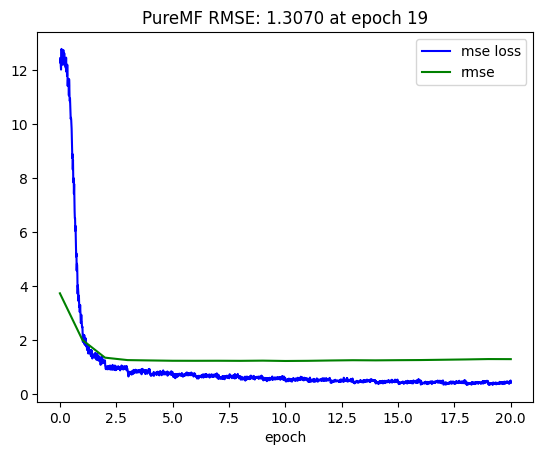

PureMF RMSE: 1.3070 at epoch 19


In [11]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 20
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []

with torch.no_grad():
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'PureMF RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'PureMF RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

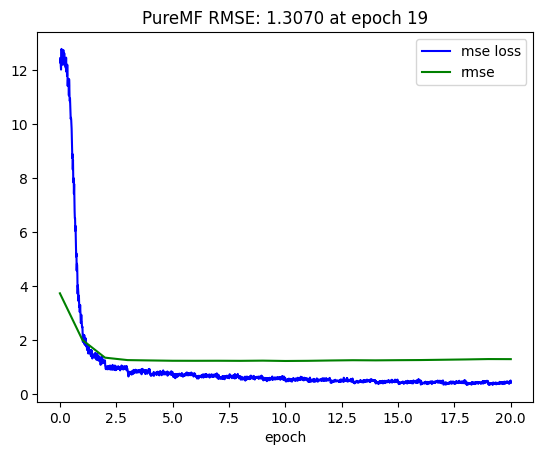

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'PureMF RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [13]:
rmse_list

[3.745628479195794,
 2.0156106874416144,
 1.362075097210943,
 1.271350296850174,
 1.2584277241821862,
 1.2468246182084137,
 1.2455122975278694,
 1.2473369842005573,
 1.2439631600521353,
 1.2513023744305587,
 1.2387241089056145,
 1.2446891976588434,
 1.257110304921905,
 1.2669024672539393,
 1.261763439036604,
 1.268317995609443,
 1.273188092667978,
 1.2843355845693907,
 1.2956830717506749,
 1.3096516901798982,
 1.3069674278496852]

In [14]:
# max(recall_list), min(rmse_list) 
print(f'PureMF Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

PureMF Min RMSE: 1.2387 at epoch 10
